# Disaster Tweets
casey.durfee@colorado.edu

## Description of Problem
We are looking at a set of messages (tweets) from Twitter which may or may not be about some type of emergency. Our goal is to build a classifier to determine whether the tweets are about real disasters versus, say, calling somebody's outfit a disaster. Such a tool could help to pull meaning out of the constant stream of twitter tweets.

In [126]:
import numpy as np
import pandas as pd
import keras
import tensorflow
from keras import layers
import matplotlib.pyplot as plt

In [127]:
BASE_DIR = "/kaggle/input/nlp-getting-started"

train = pd.read_csv(BASE_DIR + "/train.csv")
train[~train.keyword.isna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


## Exploratory Data Analysis

let's look at some basic stats about the fields.

In [128]:
print(train.describe())
train.info()

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


So we have 7613 tweets to work with, 43% of which are classified as "1". How long are these tweets?

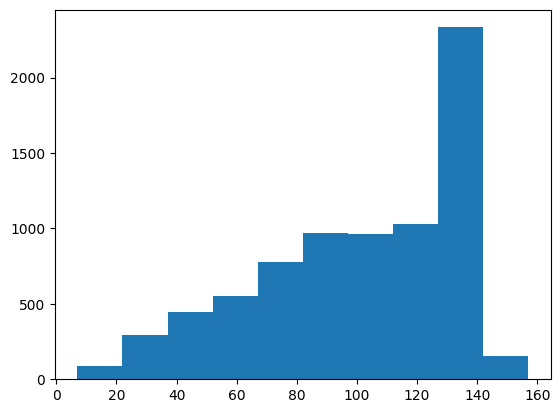

In [129]:
plt.hist(train.text.str.len())

plt.show()

What about the keyword field?

In [130]:
train.keyword.value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

almost all the tweets have keywords, so they could very well be useful. 

## Train/Validation split

Because of the techniques we're using here, we need to split up training and validation right away so words that are only in the validation set don't get into the training data.

In [224]:
train_set_df = train.sample(frac=.8)
val_set_df = train[~train.index.isin(train_set_df.index)]

print(len(train_set_df))
print(len(val_set_df))

train_set_df.head()

6090
1523


,id,keyword,location,text,target
1774,2547,collision,"Denver, Colorado",Motorcyclist bicyclist injured in Denver colli...,1
4879,6948,massacre,Minneapolis - St. Paul,UK police link Tunisian beach massacre with Ba...,1
744,1075,bleeding,The Great State of Texas,@Benjm1 @TourofUtah @B1Grego saw that pileup o...,1
2767,3977,devastation,Brasil,70 Years After Atomic Bombs Japan Still Strugg...,1
431,624,arsonist,ss,i be on that hotboy shit,0


Using a balanced number of real/fake tweets (based on the target value) will make training easier and results easier to interpret.

In [225]:
_vc = train_set_df.target.value_counts()
print(_vc)
# I will balance out classes (kinda rough way to do it)

disparity = _vc[0] - _vc[1]
if disparity > 0:
    to_delete = train_set_df[train_set_df.target==0].sample(disparity)
    train_set_df.drop(to_delete.index, inplace=True)

_vc2 = val_set_df.target.value_counts()
disparity = _vc2[0] - _vc2[1]
if disparity > 0:
    to_delete = val_set_df[val_set_df.target==0].sample(disparity)
    val_set_df.drop(to_delete.index, inplace=True)

val_set_df.target.value_counts()

target
0    3459
1    2631
Name: count, dtype: int64


/tmp/ipykernel_34/3235067101.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set_df.drop(to_delete.index, inplace=True)


target
1    640
0    640
Name: count, dtype: int64

## Data Cleaning

we will need to clean up the tweets to eliminate irrelevant info such as url's and non ascii characters.

In [133]:
from tensorflow.keras.preprocessing.text import Tokenizer

import re

train_samples = []
val_samples = []

import unicodedata

# taken from https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

def pre_process(text):
    """
    remove junk from tweets.
    """
    # deal with URL encoded spaces (%20)
    if type(text) is float:
        text = ""

    text = text.replace("%20", " ")
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # removing weirdness I found
    text = text.replace("Û", " ")
    text = text.replace("Û_", " ")
    text = text.replace("Û÷", " ")
    text = text.replace("ÛÏ", " ")
    
    # remove non-ascii noise
    text = remove_accents(text)
    return text.decode()

for idx, t in train_set_df.iterrows():

    tags = pre_process(t.keyword)

    pre_processed = pre_process(t.text)
    train_samples.append(f"{tags} {pre_processed}")
    
for idx, t in val_set_df.iterrows():
    tags = pre_process(t.keyword)
    pre_processed = pre_process(t.text)
    val_samples.append(f"{tags} {pre_processed}")

## Word Embeddings

Neural networks take numbers in and return other numbers as output. Words are not numbers.  So we need a way to map the words in each tweet to numbers.

There are a lot of ways to turn words into numbers. We could arbitrarily assign them based on the order we see them, for instance. Or, if we have *n* words, we could turn each word into a vector in n dimensional space, with each word getting its own dimension. But if we're turning them into vectors, why not use vectors where conceptually similar words are also close to physically similar?

GloVe is a system that does just that. I am using a copy of glove that someone added to kaggle. I experimented with the 50 dimensional and 200 dimensional versions and saw no big difference in accuracy.

the following code is heavily based on: https://keras.io/examples/nlp/pretrained_word_embeddings/ . I have included commentary on what it's actually doing.

first, we create a vocabulary of all the words in all the tweets. This maps each word seen to a number.

In [134]:
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tensorflow.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

for example, the word "dog" maps to the number 1169.

In [135]:
word_index["dog"]

1169

now we read in the glove database and get vectors for all the words in our vocabulary.

In [136]:
GLOVE_FILE_PATH = "/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt"
EMBEDDING_DIMENSIONS = 200


embeddings_index = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        if word in word_index:
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

here is the glove vector for the word "dog"

In [137]:
embeddings_index["dog"]

array([-1.3791e-01, -4.7601e-01, -5.6369e-02, -3.9082e-01, -1.7544e-01,
       -6.2244e-01, -3.9816e-01,  2.9620e-01, -6.0647e-02, -6.7017e-02,
        1.1466e-01, -3.3015e-01, -2.0318e-02,  6.0616e-01, -1.3920e-01,
        1.3896e-01, -5.4781e-01,  3.0864e-01,  1.7354e-01,  3.9927e-01,
        2.1137e-01,  1.3004e+00,  8.8030e-01,  2.3946e-01,  2.8838e-01,
       -4.6336e-01,  2.5745e-01, -3.1755e-01, -3.2877e-01, -5.9534e-01,
        2.3983e-01,  3.4159e-01,  1.2754e-01, -8.8208e-01,  1.4258e-01,
       -1.8857e-01, -1.6961e-01,  2.7808e-01, -2.4600e-01,  1.9122e-01,
        5.0244e-01,  5.3660e-01, -5.3568e-01,  2.4827e-01,  3.2561e-01,
        6.7882e-01,  9.6401e-01, -2.8892e-01,  5.1206e-01,  5.8496e-01,
       -3.1934e-02, -2.4849e-02,  8.8564e-02,  1.7360e-01,  5.4166e-01,
       -8.6743e-02, -3.8412e-01,  1.3974e-01, -7.4122e-03,  9.2210e-01,
       -2.5799e-01, -4.7018e-01, -5.5742e-01, -2.1213e-02, -7.1072e-01,
        8.0995e-02, -4.7254e-01, -3.2925e-01,  6.8052e-01,  1.72

now we need to create a mapping of word numbers in the vocabulary to the glove vectors. For our dog example, we want the number 1169 to map to the vector given above.

This mapping will be used by the keras Embedding layer, which will be the first layer of our neural network.

In [138]:
num_tokens = len(voc) + 2 # "padding" is 0 and "OOV" is 1 (out of vocabulary)

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIMENSIONS))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector


## A Minimum Viable Model

I like to create a simple model first, then add complexity as needed. I used this as a reference: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

A single layer bidirectional LSTM is very simple, but has the potential to be powerful because it can relate the words in the tweet to each other.

In [139]:
num_tokens = len(voc) + 2 # 0 and 1 are special values for glove.

embedding_layer = layers.Embedding(
    num_tokens,
    EMBEDDING_DIMENSIONS,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])


first_model = keras.Sequential([
    keras.Input(shape=(None,), dtype="int32"),
    embedding_layer,
    layers.Bidirectional(layers.LSTM(EMBEDDING_DIMENSIONS)),
    layers.Dense(1, activation="sigmoid")
])

first_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
first_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 200)      │     2,772,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 400)            │       641,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,414,201 (13.02 MB)

 Trainable params: 642,001 (2.45 MB)

 Non-trainable params: 2,772,200 (10.58 MB)

## Training Our First Model

we have to convert the training/validation texts to vectors.

In [140]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_set_df.target)
y_val = np.array(val_set_df.target)

In [141]:
first_history = first_model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7452 - loss: 0.5255 - val_accuracy: 0.7825 - val_loss: 0.4614
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8043 - loss: 0.4290 - val_accuracy: 0.8070 - val_loss: 0.4420
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8174 - loss: 0.4039 - val_accuracy: 0.8077 - val_loss: 0.4383
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8414 - loss: 0.3673 - val_accuracy: 0.8070 - val_loss: 0.4507
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8511 - loss: 0.3554 - val_accuracy: 0.8025 - val_loss: 0.4422
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8466 - loss: 0.3373 - val_accuracy: 0.8010 - val_loss: 0.4592
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8781 - loss: 0.2857 - val_accuracy: 0.7981 - val_loss: 0.5367
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9004 - loss: 0.2380 - val_accu

## Second Model

GRU is another Recurrent Neural Network technique that is a little simpler than LSTM but potentially more powerful. Is it better on this dataset?

In [142]:
second_model = keras.Sequential([
    keras.Input(shape=(None,), dtype="int32"),
    embedding_layer,

    layers.Bidirectional(layers.GRU(64)),

    #layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

second_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
second_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 200)      │     2,772,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │       102,144 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,874,473 (10.97 MB)

 Trainable params: 102,273 (399.50 KB)

 Non-trainable params: 2,772,200 (10.58 MB)

In [143]:
second_history = second_model.fit(x_train, y_train, batch_size=32, 
                                 epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6992 - loss: 0.5664 - val_accuracy: 0.7981 - val_loss: 0.4570
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8089 - loss: 0.4301 - val_accuracy: 0.8114 - val_loss: 0.4371
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8251 - loss: 0.3994 - val_accuracy: 0.8151 - val_loss: 0.4347
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8238 - loss: 0.3941 - val_accuracy: 0.8025 - val_loss: 0.4491
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8478 - loss: 0.3702 - val_accuracy: 0.8018 - val_loss: 0.4463
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8541 - loss: 0.3493 - val_accuracy: 0.8129 - val_loss: 0.4429
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8662 - loss: 0.3216 - val_accuracy: 0.8084 - val_loss: 0.4657
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8726 - loss: 0.3031 - val_accu

both models appeared to achieve similar results -- hitting around 80% accuracy maximum on the validation set, with further training only leading to overfitting on the training data.

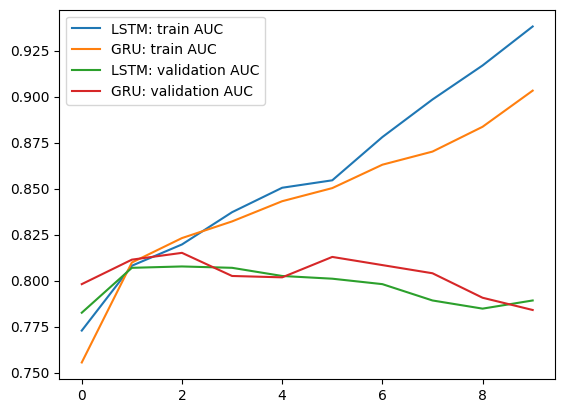

In [144]:
plt.plot(first_history.history['accuracy'], label='LSTM: train AUC')
plt.plot(second_history.history['accuracy'], label='GRU: train AUC')

plt.plot(first_history.history['val_accuracy'], label='LSTM: validation AUC')
plt.plot(second_history.history['val_accuracy'], label='GRU: validation AUC')
plt.legend()
plt.show()

So, LSTM memorizes the training set a little faster than GRU, but both top out at around 80% accuracy.

## The Third Model 
Stacked LSTMs are models with multiple LSTMs in sequence. It should be able to pick up more sophisticated patterns than a single LSTM layer.

https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

In [145]:
third_model = keras.Sequential([
    keras.Input(shape=(None,), dtype="int32"),
    embedding_layer,

    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(1, activation="sigmoid")
])

third_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
third_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 200)      │     2,772,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, None, 128)      │       135,680 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, None, 128)      │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,105,641 (11.85 MB)

 Trainable params: 333,441 (1.27 MB)

 Non-trainable params: 2,772,200 (10.58 MB)

In [146]:
third_history = third_model.fit(x_train, y_train, batch_size=32, 
                                 epochs=5, validation_data=(x_val, y_val))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.7285 - loss: 0.5219 - val_accuracy: 0.7929 - val_loss: 0.4539
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8118 - loss: 0.4265 - val_accuracy: 0.8121 - val_loss: 0.4326
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8253 - loss: 0.4024 - val_accuracy: 0.7929 - val_loss: 0.4464
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8257 - loss: 0.3914 - val_accuracy: 0.7899 - val_loss: 0.4447
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8513 - loss: 0.3482 - val_accuracy: 0.7929 - val_loss: 0.4492
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8643 - loss: 0.3285 - val_accuracy: 0.8010 - val_loss: 0.4708
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8834 - loss: 0.2917 - val_accuracy: 0.7973 - val_loss: 0.4994
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8871 - loss: 0.2674 - 

well, it looks like the more sophisticated model didn't do any better on this. What are we missing? is there a pattern to the misclassified ones? And are our two best models making the same mistakes?

In [155]:
y_pred = third_model.predict(x_train)
y_pred2 = second_model.predict(x_train)

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


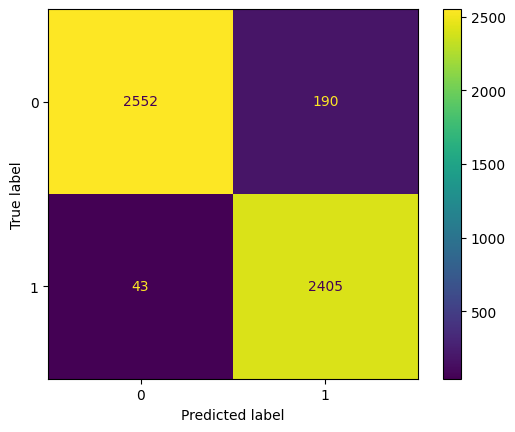

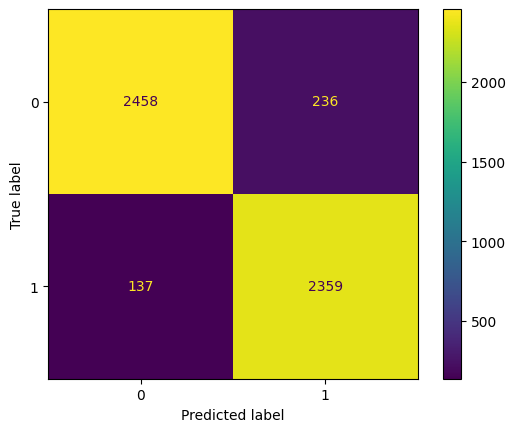

In [171]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#
b_y_pred = (y_pred > 0.5).astype(int).flatten()
b_y_pred2 = (y_pred2 > 0.5).astype(int).flatten()

confu = confusion_matrix(b_y_pred, y_train)
ConfusionMatrixDisplay(confu).plot()

confu2 = confusion_matrix(b_y_pred2, y_train)
ConfusionMatrixDisplay(confu2).plot()

We're getting more false negatives than false positives. let's see what the raw scores look like, for the second (GRU) and third (Stacked LSTM) models.

In [158]:
pred_df = pd.DataFrame({"pred_raw": y_pred.flatten(),
                        "pred_raw2": y_pred2.flatten(),
                        "pred": b_y_pred,
                        "pred2": b_y_pred2,
                        "actual": y_train, 
                        "text": train_samples})

false_negs = pred_df[(pred_df.pred==0) & (pred_df.actual==1)]
false_negs.head()

,pred_raw,pred_raw2,pred,pred2,actual,text
72,0.307293,0.935116,0,1,1,wounded The Police Chief assured the crowd tha...
95,0.338816,0.453029,0,0,1,terrorist HereUas how media in Pakistan covere...
97,0.422432,0.498812,0,0,1,detonation Dorman 917-033 Ignition Knock (Deto...
101,0.326866,0.146786,0,0,1,engulfed @godsfirstson1 and she wrapped his co...
115,0.020030,0.108024,0,0,1,panicking all that panicking made me tired ;__...


<Axes: >

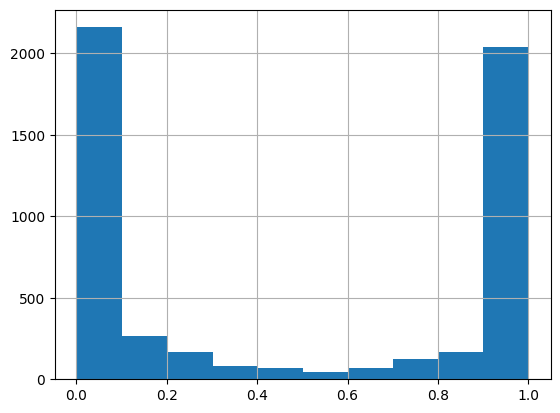

In [159]:
pred_df.pred_raw.hist()

The raw scores are all pretty concentrated close to 0 or 1. seems it's missing on the ones in the middle. Maybe a simple suite where we average the two models would do better?

In [185]:
THRESH=.5

suite_predictions = np.mean([y_pred,  y_pred2], axis=0)

b_suite_predictions = (suite_predictions > THRESH).astype(int).flatten()

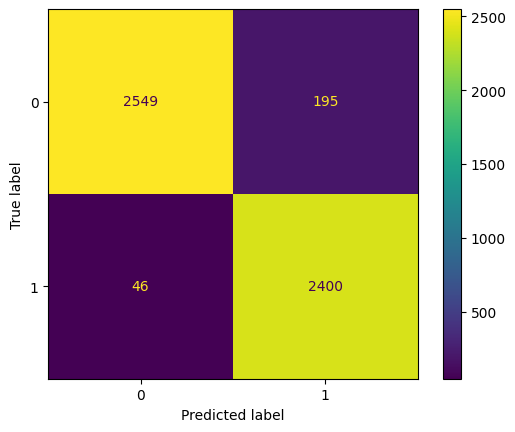

In [188]:
confu3 = confusion_matrix(b_suite_predictions, y_train)
ConfusionMatrixDisplay(confu3).plot()

The suite model has even more false negatives, and more wrong guesses overall, if we add together Type I and Type II errors.

In [ ]:
print(confu[0,1] + confu[1,0])
print(confu2[0,1] + confu2[1,0])
print(confu3[0,1] + confu3[1,0])


231
373
241


## Hyperparameter Tuning

One easy hyperparameter to tweak is the threshold on whether we return a "0" or a "1". Let's see if a different threshold would give better results for the suite.


In [196]:
GENERATE = False
if GENERATE:
    suite_predictions = np.mean([y_pred,  y_pred2], axis=0)
    print("threshold|wrong answers")
    print("---------|-------------")
    for test_thresh in [.2,.3,.4,.5,.6]:
        b_suite_predictions = (suite_predictions > test_thresh).astype(int).flatten()
        _confu = confusion_matrix(b_suite_predictions, y_train)    
        print(f"{test_thresh}|{_confu[0,1] + _confu[1,0]}")

we can see that a threshold of .4 actually does a little better than .5. Let's try to find a more exact value.

threshold|wrong answers
---------|-------------
0.2|482
0.3|303
0.4|231
0.5|241
0.6|272

In [212]:
suite_predictions = np.mean([y_pred,  y_pred2], axis=0)
print("threshold|wrong answers")
print("---------|-------------")

best_thresh = np.nan
best_wrong = 9999999

for test_thresh in np.arange(.35,.5,.005):
    b_suite_predictions = (suite_predictions > test_thresh).astype(int).flatten()
    _confu = confusion_matrix(b_suite_predictions, y_train)
    total_wrong = _confu[0,1] + _confu[1,0]
    print(f"{round(test_thresh,3)}\t|\t{total_wrong}")
    if total_wrong < best_wrong:
        best_thresh = test_thresh
        best_wrong = total_wrong
    
print(f"\n\nbest threshold was {best_thresh}")
    

threshold|wrong answers
---------|-------------
0.35	|	253
0.355	|	248
0.36	|	248
0.365	|	246
0.37	|	241
0.375	|	238
0.38	|	239
0.385	|	240
0.39	|	238
0.395	|	234
0.4	|	231
0.405	|	227
0.41	|	229
0.415	|	229
0.42	|	229
0.425	|	228
0.43	|	229
0.435	|	230
0.44	|	229
0.445	|	232
0.45	|	231
0.455	|	233
0.46	|	233
0.465	|	232
0.47	|	232
0.475	|	233
0.48	|	231
0.485	|	234
0.49	|	238
0.495	|	237
0.5	|	241


best threshold was 0.405


Did that actually improve things? we need to generate predictions for the validation set using this new threshold.

In [206]:
y_val_pred = third_model.predict(x_val)
y_val_pred2 = second_model.predict(x_val)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


accuracy: 0.7855029585798816


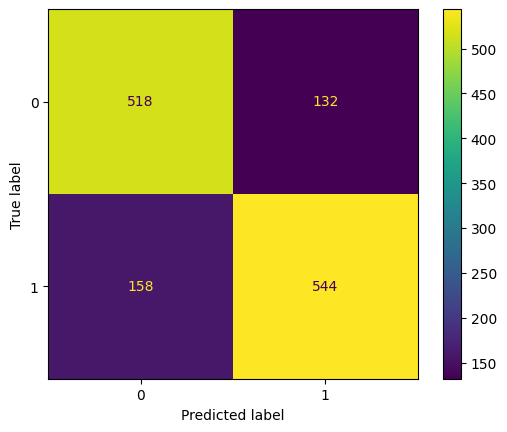

In [213]:
suite_predictions = np.mean([y_val_pred,  y_val_pred2], axis=0)
b_suite_predictions = (suite_predictions > best_thresh).astype(int).flatten()


confu4 = confusion_matrix(b_suite_predictions, y_val)

accuracy = 1- ((confu4[0,1] + confu4[1,0]) / len(y_val))

ConfusionMatrixDisplay(confu4).plot()

print(f"accuracy: {accuracy}")

Unfortunately, accuracy on the suite isn't any better than for the base models (roughly 79%). so in this case, the suite didn't help even though we tried tuning it.

## Conclusions
The biggest takeaway is that there isn't much difference between the models, despite different architectures and levels of complexity. all of them hit roughly the same accuracy score.

Model|Best Accuracy Score
-----|--------------
Trivial LSTM | .8077
GRU | .8151
Stacked LSTM | .8121
Suite | .7855

The suite performed a little worse than the individual models, even after trying to tune the threshold.

It seems like all the models are hitting the limits of what can be done with a simple RNN on this problem.

## Next Steps

I could have done more with keywords rather than just adding them to the text. I think some keywords would be correlated strongly with real/fake tweets.

There is definitely room for better cleaning of the data. However, I initially trained the models on text that hadn't been cleaned of non-ASCII characters and other junk, and it was around 80% accuracy as well. So I didn't see evidence that more cleaning would radically improve the score.

There are other encoding schemes besides glove, but both the 50 dimensional and 200 dimensional versions of glove gave similar results in my informal testing (not shown here).

The suite could incorporate more than 2 separate models. with 3 models, we could use consensus rather than averaging the scores.

Using an existing large language model would probably work better than this approach, especially one tuned towards processing tweets. I think sentiment analysis info might help the model classify whether something is a natural disaster, or just a "fashion disaster".

In [229]:
# submitting to kaggle

sample = open(BASE_DIR + "/sample_submission.csv")
data = sample.read()

data[:100]

test_data = pd.read_csv(BASE_DIR + "/test.csv")

test_data[~test_data.keyword.isna()].head()

,id,keyword,location,text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...


In [233]:
test_samples = []

for idx, t in test_data.iterrows():

    tags = pre_process(t.keyword)

    pre_processed = pre_process(t.text)
    test_samples.append(f"{tags} {pre_processed}")
    
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

In [235]:
pred_test = third_model.predict(x_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [238]:
b_pred_test = (pred_test > 0.5).astype(int).flatten()

submission = pd.DataFrame({'id': test_data.id, 'target': b_pred_test})
submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [240]:
submission.target.value_counts()

target
0    1932
1    1331
Name: count, dtype: int64

In [241]:
submission.to_csv("submission.csv", index=False)

## Sources
* https://keras.io/examples/nlp/bidirectional_lstm_imdb/
* https://keras.io/examples/nlp/pretrained_word_embeddings/
* https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
* https://huggingface.co/blog/sentiment-analysis-twitter
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/